In [1]:
from nilearn import plotting
import numpy as np
import nibabel as nb
import nibabel.processing as nbp
from nilearn.image import resample_to_img
import os

In [2]:
# define paths
root_dir = '/users3/uccibit/alexsayal/BIDS-BRAINPLAYBACK-TASK2'
fmriprep_dir = os.path.join(root_dir, 'derivatives/fmriprep23')
dataset_dir = os.path.join(root_dir, 'derivatives/mvpa_ls_a_data')
brain_dir = os.path.join(root_dir, 'derivatives','mni_icbm152_t1_tal_nlin_asym_09c.nii')
mask_dir = os.path.join(root_dir, 'derivatives','mni_icbm152_t1_tal_nlin_asym_09c_mask.nii')

In [3]:
# list datasets and concatenate

# find all *_dataset.nii.gz files in dataset_dir
dataset_files = [os.path.join(dataset_dir, f) for f in os.listdir(dataset_dir) if f.endswith('_dataset.nii.gz')]
dataset_files.sort()

# find all *_trial_types.txt files in dataset_dir
label_files = [os.path.join(dataset_dir, f) for f in os.listdir(dataset_dir) if f.endswith('_trial_types.txt')]
label_files.sort()

In [4]:
# concatenate all datasets
D = nb.concat_images(dataset_files, axis=3)

In [5]:
# save concatenated dataset
D.to_filename(os.path.join(dataset_dir, 'all_datasets.nii.gz'))

In [6]:
# concatenate all labels into a single string array
labels = np.concatenate([np.loadtxt(l, dtype=str) for l in label_files])

# trim each label to remove '___1' and '___2' suffixes
labels = np.array([l.split('___')[0] for l in labels])

In [7]:
# save concatenated labels
np.savetxt(os.path.join(dataset_dir, 'all_labels.txt'), labels, fmt='%s')

In [8]:
# load dataset and labels
#D = nb.load(os.path.join(dataset_dir, 'all_datasets.nii.gz'))
#labels = np.loadtxt(os.path.join(dataset_dir, 'all_labels.txt'), dtype=str)

In [8]:
#mask = nb.load(mask_dir)
#mask_downsampled = nbp.resample_to_output(mask, [2,2,2])

mask_resampled = resample_to_img(mask_dir, D)
# Binarize ROI template
data_binary = np.array(mask_resampled.get_fdata()>=0.5, dtype=np.int8)

# Dilate binary mask once
from scipy.ndimage import binary_dilation
data_dilated = binary_dilation(data_binary, iterations=2).astype(np.int8)

# Save binary mask in NIfTI image
mask = nb.Nifti1Image(data_dilated, mask_resampled.affine, mask_resampled.header)
mask.set_data_dtype('i1')


In [9]:
#from nilearn.plotting import plot_roi
#plot_roi(mask, brain_dir, cmap='Paired', dim=-.5, draw_cross=False, annotate=False)

ValueError: File not found: '/users3/uccibit/alexsayal/BIDS-BRAINPLAYBACK-TASK2/derivatives/mni_icbm152_t1_tal_nlin_asym_09c.nii'

In [10]:
from nilearn.input_data import NiftiMasker
masker = NiftiMasker(mask_img=mask, standardize=False, detrend=False)
samples = masker.fit_transform(D)
print(samples)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [11]:
# masked and z-scored BOLD series
D_masked = masker.inverse_transform(samples)

In [12]:
# generate an array of chunk labels
# so 2 x 4 x 9 ones, 2 x 4 x 9 twos, etc. up to twelve
chunks = np.repeat(np.arange(1,14), 9*4*2)
#chunks = np.ravel([np.zeros(9),np.ones(9)])
chunks.shape

(936,)

In [13]:
# Create two masks that specify the training and the test set 
mask_test = chunks == 5
mask_train = np.invert(mask_test)

In [14]:
# Apply this sample mask to X (fMRI data) and y (behavioral labels)
from nilearn.image import index_img
X_train = index_img(D, mask_train)
y_train = labels[mask_train]

X_test = index_img(D, mask_test)
y_test = labels[mask_test]

In [15]:
from nilearn.decoding import SpaceNetClassifier

# Fit model on train data and predict on test data
decoder = SpaceNetClassifier(penalty='tv-l1',
                             mask=mask,
                             max_iter=1000,
                             cv=12,
                             standardize=True,
                             memory=os.path.join(root_dir, 'derivatives',"nilearn_cache"),
                             memory_level=2,
                             n_jobs=30,
                             verbose=1)



In [16]:
decoder.fit(X_train, y_train)

[NiftiMasker.fit] Loading data from None
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 864),
affine=array([[   2. ,    0. ,    0. ,  -96.5],
       [   0. ,    2. ,    0. , -132.5],
       [   0. ,    0. ,    2. ,  -78.5],
       [   0. ,    0. ,    0. ,    1. ]])
)
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals


/users3/uccibit/alexsayal/miniconda3/envs/mvpa/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:570: UserWarning: Persisting input arguments took 21.13s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  data = self._cache(
/tmp/ipykernel_877699/1253004724.py:1: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  decoder.fit(X_train, y_train)
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


: 

: 

: 

In [ ]:
# Predict the labels of the test data
y_pred = decoder.predict(X_test)

[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 72),
affine=array([[   2. ,    0. ,    0. ,  -96.5],
       [   0. ,    2. ,    0. , -132.5],
       [   0. ,    0. ,    2. ,  -78.5],
       [   0. ,    0. ,    0. ,    1. ]])
)
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals


/DATAPOOL/home/alexandresayal/anaconda3/envs/brainplayback_task01/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:570: UserWarning: Persisting input arguments took 2.86s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  data = self._cache(


In [ ]:
# Re run average accuracy
accuracy = (y_pred == y_test).mean() * 100.
print("\nTV-l1  classification accuracy : %g%%" % accuracy)


TV-l1  classification accuracy : 12.5%


In [ ]:
from nilearn.plotting import plot_stat_map, show
coef_img = decoder.coef_img_

In [ ]:
coef_img.shape

(97, 115, 97, 9)

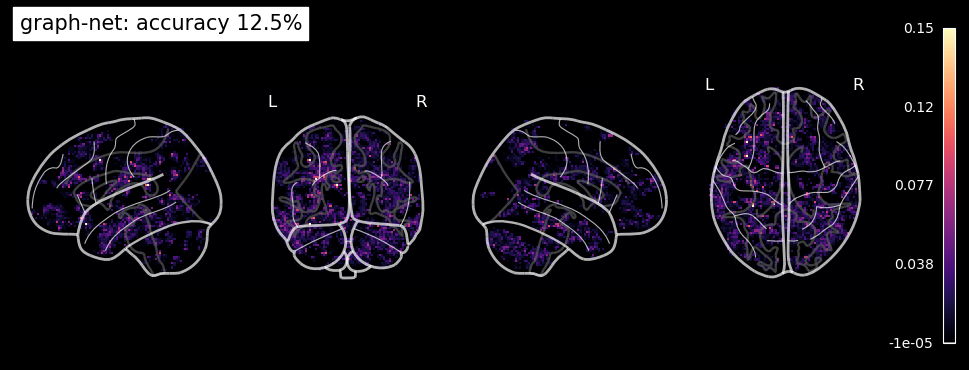

In [ ]:
# Plotting the searchlight results on the glass brain
from nilearn.plotting import plot_glass_brain
plot_glass_brain(coef_img.slicer[...,4], black_bg=True, colorbar=True, display_mode='lyrz', symmetric_cbar=False,
                 cmap='magma', title='graph-net: accuracy %g%%' % accuracy)